# Adaptive Climate System

A simplified 0-D, time-varying model of the Earth's energy balance:

$$\rho c_p H \frac{dT}{dt} = R -  bT$$

- $T$ is the global average surface temperature (relative to pre-industrial) [$C$]
- $b$ is the climate sensitivity parameter [$Wm^{-2} C ^{-1}$]
- $H$ is the ocean mixed layer depth [$m$]
- $R$ is radiative forcing [$Wm^{-2}$]
- $\rho$ is the density of sea water [$kgm^{-3}$]
- $c_p$ is the specific heat capacity of seawater [$Jkg^{-1} C^{-1}$]

The simple climate model is an energy balance model that accounts for feedbacks, natural variability, and an ocean to help simulate the main components that determine changes in global mean temperature.


In [125]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Plot options
plt.rcParams["figure.autolayout"] = True
plt.style.use('seaborn')


In [126]:
class ClimateSystem:
    def __init__(self):
        """
        Initialize constants and parameters
        """
        # climate sensitivity
        # this should depend on a climate sensitivity model
        self.b = self.estimate_climate_sensitivity()

        # ocean mixed layer depth (kg/m^3)
        self.H = 300

        # radiative forcing (W/m^2)
        self.R = 0.5

        # density of sea water (kg/m^3)
        self.rho = 1025

        # heat capacity of sea water (J/kg/K)
        self.c_p = 3985

        # change in time (s), this is the value for a year in seconds
        self.delta_t = 365.25*24*60*60  # seconds

        # forcing types
        self.forcing_types = ['Forcing RCP26 [W/m2]', 'Forcing RCP45 [W/m2]',
                              'Forcing RCP6 [W/m2]', 'Forcing RCP85 [W/m2]']

        self.predicted_temps_by_projected_forcings = []

        # get data
        data_and_projections = self.get_data()
        self.data = data_and_projections[0]
        self.projections = data_and_projections[1]

    def get_data(self):
        """
        Reads in data from a csv file and returns a pandas dataframe
        """

        data = pd.read_csv('data/climate_forcing_1880-2006.csv')
        projections = pd.read_csv('data/climate_forcing_projected.csv')
        return data, projections

    def get_forcing(self, key):
        """
        Returns the radiative forcing for a given key
        """
        return self.data['Year'], self.data[key]

    def get_total_forcing(self):
        """
        Returns the total radiative forcing
        """
        return self.data['Year'], self.data['Total radiative forcing [W/m2]']

    def get_forcing_projections(self, key):
        """
        Returns the radiative forcing for a given scenario
        """
        return self.projections['Year'], self.projections[key]

    def get_observed_temp(self):
        """
        Returns the observed temperature
        """
        return self.data['Year'], self.data['Observed Temperature [C]']

    def predict_temp(self, forcings, b, H):
        """
        Returns the predicted temperature for a given set of forcings
        over a time series.

        The model equation is stepped forward in time using Euler's method.
        """
        steps = len(forcings)

        # initialize temperature array
        temps = np.zeros(steps)

        # loop through time steps and solve model equation
        for i in range(steps-1):
            dTdt = (forcings[i]-b*temps[i])/(self.rho*self.c_p*H)
            temps[i+1] = temps[i]+dTdt*self.delta_t

        return temps

    def plot_temps_by_forcings(self, forcing_types, b=None, H=None):
        """
        Plots the predicted temperature against the radiative forcing(s) given
        """
        fig, ax = plt.subplots(nrows=1, ncols=len(
            forcing_types), figsize=(20, 5))
        estimated_climate_sensitivity = b if b else self.b
        ocean_mixed_layer_depth = H if H else self.H

        for i in range(len(forcing_types)):
            year, data = self.get_forcing_projections(forcing_types[i])
            self.predicted_temps_by_projected_forcings.append(self.predict_temp(
                data, estimated_climate_sensitivity, ocean_mixed_layer_depth))

            ax[i].plot(
                year, self.predicted_temps_by_projected_forcings[i], '-', label='Predicted')
            ax[i].set_xlabel('Year')
            ax[i].set_ylabel('[$^{\circ}C$]')
            ax[i].set_title(
                'Predicted temperature for ' + forcing_types[i])
            ax[i].set_ylim(0, 5)
            ax[i].legend()

        print("estimated climate sensitivity, b:",
              estimated_climate_sensitivity)
        print("ocean mixed layer depth, H: ", ocean_mixed_layer_depth)

    def get_forcing_growth_rate(self, forcings):
        """
        Returns the growth rate of the radiative forcing, a single value
        """
        return np.mean(forcings)

    def estimate_climate_sensitivity(self, fixed: bool = True):
        """
        The given estimate of climate sensitivity by IPCC is 1.5[deg C] - 4.5[deg C], 
        and is fairly close to 3[deg C] average across different studies with some reporting very-high or very-low sensitivity.

        This function returns a value from the a uniform distribution between the two extremes.
        """
        # seed random number generator
        if fixed:
            np.random.seed(1)
        return np.random.uniform(1.5, 4.5)

    def adapt_with_chaos(self, forcing_type):
        """
        Generates forcings for a time series using a logistic map function
        """

        years, forcings = self.get_forcing(forcing_type)

        # This forcing is from observed temperature, using it learn
        r = self.get_forcing_growth_rate(forcings)

        # get max value in forcing
        Pmax = max(forcings)

        Pn = forcings[0]

        xn = Pn/Pmax

        time_steps = len(years)

        # logistic map function
        def chaos(r, x):
            """
            xn+1 = rxn(1 − xn)

            xn is the population expressed as a fraction as the maximum possible, 
            or “doomsday” population. Therefore xn = Pn / Pmax, where Pn is the
            current population and Pmax is the maximum possible population.

            r is the growth rate
            """
            return r * x * (1 - x)

        # initialize array to store chaos values
        chaos_values = np.zeros(time_steps)

        for i in range(time_steps):
            chaos_values[i] = chaos(r[i], xn)
            xn = chaos_values[i]

        # plot chaos values
        plt.plot(years, chaos_values)
        plt.show()


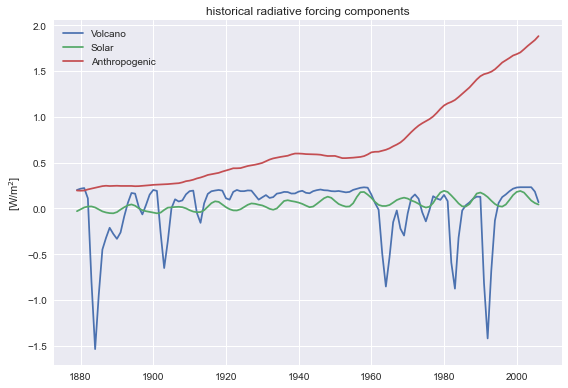

In [127]:
climate = ClimateSystem()

plt.figure()
plt.plot(*climate.get_forcing('Volcano [W/m2]'), label='Volcano')
plt.plot(*climate.get_forcing('Solar [W/m2]'), label='Solar')
plt.plot(*climate.get_forcing('Anthropogenic [W/m2]'), label='Anthropogenic')
plt.ylabel('[W/m$^2$]')
plt.title('historical radiative forcing components')
plt.legend()


## Anthropogenic effect

"Representative Concentration Pathways (RCPs) are not new, fully integrated scenarios (i.e., they are not a complete package of socioeconomic, emissions and climate projections). They are consistent sets of projections of only the components of radiative forcing that are meant to serve as input for climate modeling, pattern scaling and atmospheric chemistry modeling," according to the RCP Database.

This is the parameter we are investigating and eventually going to adapt.

### Historical Data

Let's see how much human forcing we have in the dataset


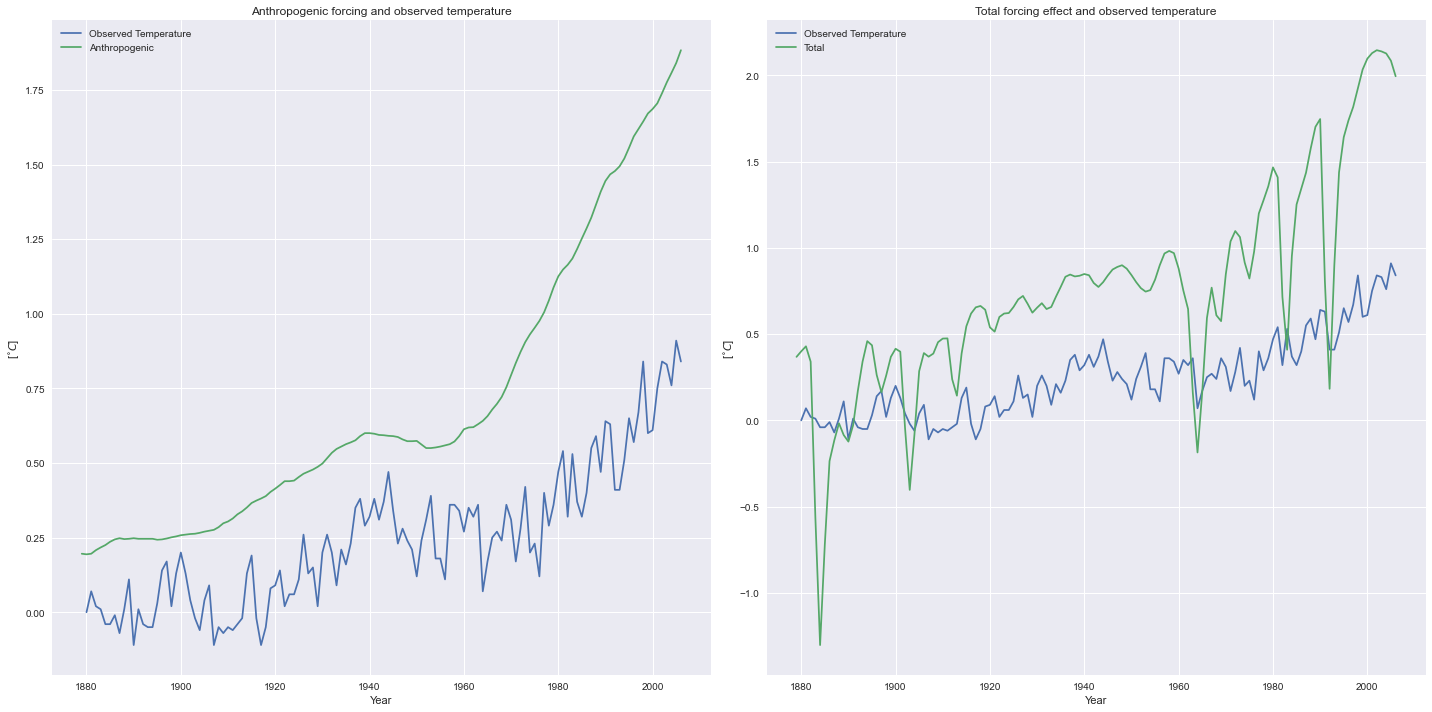

In [120]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))

ax[0].plot(*climate.get_observed_temp(), label='Observed Temperature')
ax[0].plot(*climate.get_forcing('Anthropogenic [W/m2]'), label='Anthropogenic')
ax[0].set_xlabel('Year')
ax[0].set_ylabel('[$^{\circ}C$]')
ax[0].set_title('Anthropogenic forcing and observed temperature')
ax[0].legend()

ax[1].plot(*climate.get_observed_temp(), label='Observed Temperature')
ax[1].plot(*climate.get_total_forcing(), label='Total')
ax[1].set_xlabel('Year')
ax[1].set_ylabel('[$^{\circ}C$]')
ax[1].set_title('Total forcing effect and observed temperature')
ax[1].legend()


### Projections


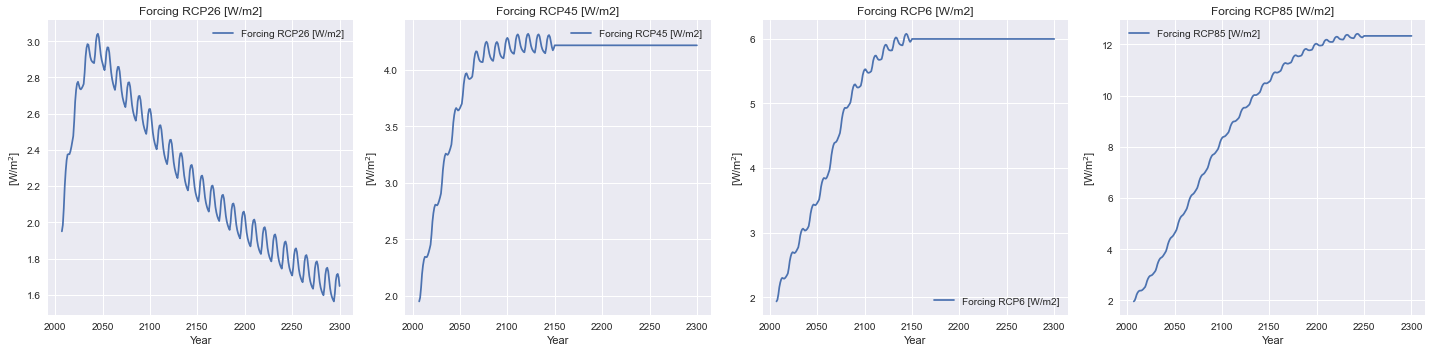

In [121]:
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))

for i in range(len(climate.forcing_types)):
    ax[i].plot(*climate.get_forcing_projections(climate.forcing_types[i]), label=climate.forcing_types[i])
    ax[i].set_xlabel('Year')
    ax[i].set_ylabel('[W/m$^2$]')
    ax[i].set_title(climate.forcing_types[i])
    ax[i].legend()


Now we can ask why the decline after the peak at sometime around 2050, it could be a collapse of the climate system. Discuss what further studies say.


# Best fit to data

Find the best fit for $H$ and $b$ i.e ocean mixed layer depth [$m$] and climate sensitivity [$Wm^{-2} C^{-1}$] respectively


estimated climate sensitivity, b: 2.751066014107722
ocean mixed layer depth, H:  300


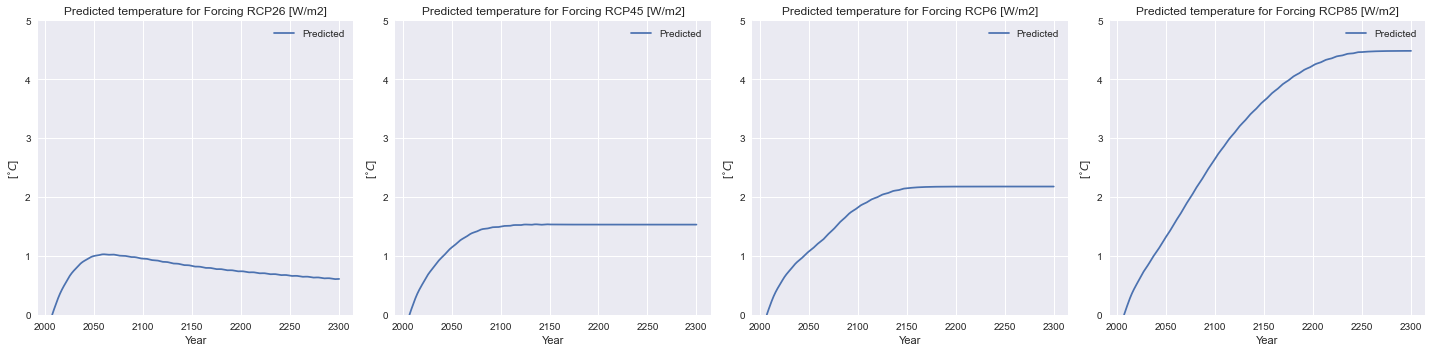

In [122]:
climate.plot_temps_by_forcings(climate.forcing_types)

## Using a chaotic regime to generate projections

Using the logistic map


“sensitive dependence on initial conditions”. This case we would use climate sensitivity


r = 0.7443750000000002
x0 = [0.213986013986014]


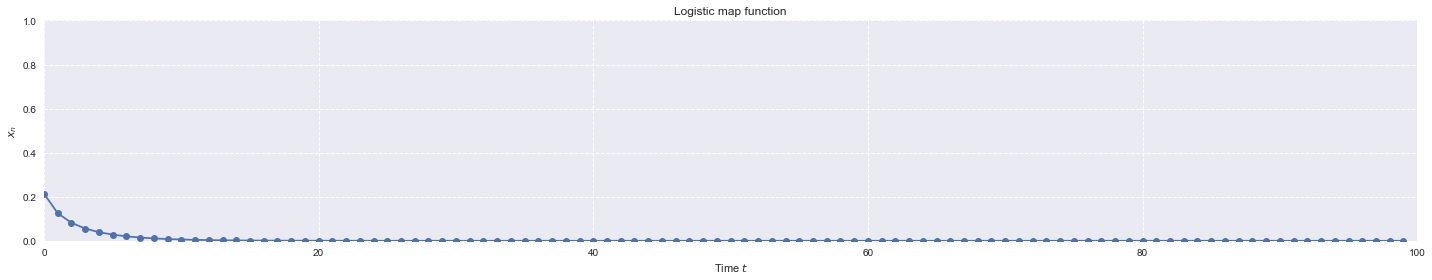

In [137]:
# Logistic map function
def chaos(r, x):
    """
    xn+1 = rxn(1 − xn)

    xn is the population expressed as a fraction as the maximum possible, 
    or “doomsday” population. Therefore xn = Pn / Pmax, where Pn is the
    current population and Pmax is the maximum possible population.

    r is the growth rate
    """
    return r * x * (1 - x)


years, data = climate.get_total_forcing()

max_value = max(data)

x = data[15]/max_value

time_step = 100
r = climate.get_forcing_growth_rate(data)
# r = climate.estimate_climate_sensitivity(fixed=False)
x0 = [x]

# initialize array to store chaos values
chaos_values = [np.array([initial, *np.zeros(time_step-1)]) for initial in x0]

for i in range(len(chaos_values)):
    for j in range(time_step-1):
        chaos_values[i][j+1] = chaos(r, chaos_values[i][j])

# plot chaos values
# set y axis to be between 0 and 1
plt.figure(figsize=(20, 4))
plt.grid(linestyle='--')
plt.title('Logistic map function')
plt.ylabel('$x_n$')
plt.xlabel('Time $t$')
plt.ylim(0, 1)
plt.xlim(0, time_step)
for i in range(len(chaos_values)):
    plt.plot(chaos_values[i], '-o')

# print the parameters of the chaos
print('r =', r)
print('x0 =', x0)


### Test


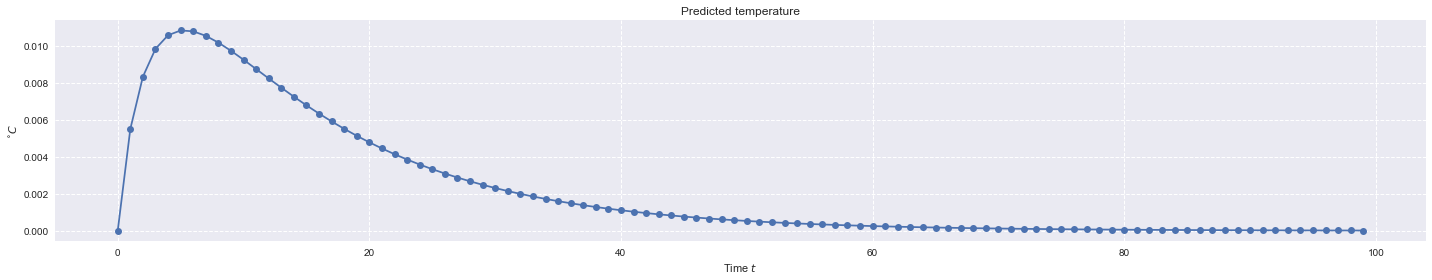

In [138]:
temps = climate.predict_temp(*chaos_values, climate.estimate_climate_sensitivity(), 300)

# plot the predicted temperature
plt.figure(figsize=(20, 4))
plt.grid(linestyle='--')
plt.title('Predicted temperature')
plt.ylabel('$^{\circ}C$')
plt.xlabel('Time $t$')
plt.plot(temps, '-o')
